<a href="https://colab.research.google.com/github/Rashu0304/CNN/blob/main/Image_classificaion_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Objective:

> The objective of this project is to build a Convolutional Neural Network (CNN) model using TensorFlow and Keras to classify images into three categories: Buildings, Forest, and Sea. The model will be trained on a dataset of images, evaluated for accuracy, and deployed using Gradio for real-time predictions. The project also includes data preprocessing, augmentation, and visualization of training and validation metrics.

## Step1: Import All dependencies

In [1]:
# !pip install  -q tensorflow
!pip install  -q  gradio

In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.18.0


* TensorFlow and Gradio are installed for building and deploying the model.

* Necessary libraries for data processing, model building, and visualization are imported.

* A random seed is set to ensure reproducibility.





## Step 2: Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir("/content/drive/MyDrive/DEEP LEARNING PROJECT/IMAGE CLASSIFICATION USING CNN")

In [5]:


# # Extract dataset.rar file (Run only First Time)
!pip install patool
import patoolib
patoolib.extract_archive("dataset.rar")
# patoolib.extract_archive("test_examples.rar")

INFO patool: Extracting dataset.rar ...
INFO:patool:Extracting dataset.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/drive/MyDrive/DEEP LEARNING PROJECT/IMAGE CLASSIFICATION USING CNN/dataset.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/drive/MyDrive/DEEP LEARNING PROJECT/IMAGE CLASSIFICATION USING CNN/dataset.rar"
INFO patool: ... dataset.rar extracted to `dataset1' (local file exists).
INFO:patool:... dataset.rar extracted to `dataset1' (local file exists).


'dataset1'

In [6]:
!dir

cnn_model_100.h5  dataset  dataset1  dataset.rar  test_examples.rar  Untitled0.ipynb


* Google Drive is mounted to access the dataset stored in the cloud.

* The dataset is extracted using the patool library.

* The working directory is set to the location of the dataset.

## Step 3: Build CNN Model

In [7]:
# create CNN model
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):

        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, chanel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(150, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # third set of CONV => RELU => POOL layers
        model.add(Conv2D(200, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # ------------------------ANN-----------------------
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(2000))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


* The LeNet architecture is defined with three sets of convolutional layers followed by fully connected layers.

* The model uses ReLU activation and softmax for classification.

## Step 4: Data Reading

In [8]:
DATASET = "dataset"  # this folde must contain three subfolder with images
MODEL = "Scene.model" # name to store the model on disk
PLOT = "plot.png" # plot name

In [9]:
# initialize the data and labels
print("[INFO] loading images...")
data = []  # x
labels = [] # y

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)

# progress bar
with tqdm(total=len(imagePaths)) as pbar:
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        if label == "Buildings":
            label = 0
        elif label == "Forest":
            label = 1
        elif label == "Sea":
            label = 2
        labels.append(label)
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/883 [00:00<?, ?it/s]

In [10]:
# check shape of single image
data[0].shape

(28, 28, 3)

In [11]:
data[0]

array([[[ 91.,  86.,  83.],
        [ 42.,  35.,  34.],
        [ 23.,  26.,  24.],
        ...,
        [ 60.,  50.,  50.],
        [ 18.,  19.,  17.],
        [133., 131., 127.]],

       [[ 44.,  39.,  38.],
        [ 76.,  73.,  72.],
        [ 18.,  20.,  18.],
        ...,
        [102.,  93.,  90.],
        [ 20.,  19.,  18.],
        [ 92.,  85.,  82.]],

       [[ 59.,  55.,  54.],
        [ 40.,  39.,  37.],
        [ 32.,  35.,  31.],
        ...,
        [149., 139., 139.],
        [ 20.,  19.,  16.],
        [ 38.,  33.,  30.]],

       ...,

       [[170., 128., 105.],
        [149., 120.,  99.],
        [182., 147., 117.],
        ...,
        [195., 158., 130.],
        [196., 157., 124.],
        [208., 169., 137.]],

       [[185., 145., 115.],
        [154., 120.,  96.],
        [170., 140., 107.],
        ...,
        [192., 158., 129.],
        [198., 159., 126.],
        [206., 167., 135.]],

       [[158., 122.,  98.],
        [175., 139., 114.],
        [167., 1

* Images are loaded, resized, and converted to arrays.

* Labels are extracted from the image paths and converted to numerical values.

## Step 5: Data Spliting

In [12]:
# perform data normalisation
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [13]:
data[0]

array([[[0.35686275, 0.3372549 , 0.3254902 ],
        [0.16470588, 0.1372549 , 0.13333333],
        [0.09019608, 0.10196078, 0.09411765],
        ...,
        [0.23529412, 0.19607843, 0.19607843],
        [0.07058824, 0.0745098 , 0.06666667],
        [0.52156863, 0.51372549, 0.49803922]],

       [[0.17254902, 0.15294118, 0.14901961],
        [0.29803922, 0.28627451, 0.28235294],
        [0.07058824, 0.07843137, 0.07058824],
        ...,
        [0.4       , 0.36470588, 0.35294118],
        [0.07843137, 0.0745098 , 0.07058824],
        [0.36078431, 0.33333333, 0.32156863]],

       [[0.23137255, 0.21568627, 0.21176471],
        [0.15686275, 0.15294118, 0.14509804],
        [0.1254902 , 0.1372549 , 0.12156863],
        ...,
        [0.58431373, 0.54509804, 0.54509804],
        [0.07843137, 0.0745098 , 0.0627451 ],
        [0.14901961, 0.12941176, 0.11764706]],

       ...,

       [[0.66666667, 0.50196078, 0.41176471],
        [0.58431373, 0.47058824, 0.38823529],
        [0.71372549, 0

In [14]:
# Split the data into train test
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [15]:
# verify shapes
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(662, 28, 28, 3)
(221, 28, 28, 3)
(662,)
(221,)


In [16]:
trainY[0] # 1

1

In [17]:
# Perform one hot label encoding
trainY = to_categorical(trainY, num_classes=3)
testY = to_categorical(testY, num_classes=3)

In [18]:
trainY[0]

array([0., 1., 0.])

* Data is normalized to the range [0, 1].

* The dataset is split into training and testing sets.

* Labels are one-hot encoded for multi-class classification.

## Step 6: Data Preprocessing (Augumentation)

In [19]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

* Data augmentation is applied to increase the diversity of the training data.

## Step 7: Compile and Training

In [20]:
INIT_LR = 1e-3
BS = 64

# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=3)
opt = Adam(learning_rate=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [21]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 50)          │           3,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 150)         │         187,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 14, 14, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 150)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 200)           │         750,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 7, 7, 200)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 200)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1800)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2000)                │       3,602,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           6,003 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 3)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,549,653 (17.36 MB)

 Trainable params: 4,549,653 (17.36 MB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
# train the network

EPOCH  = 100
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCH,
              verbose=1)

# save the model and label binarizer to disk
print("[INFO] serializing network ...")
model.save("cnn_model_{}.h5".format(EPOCH))

[INFO] training network...
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.4578 - loss: 1.1397 - val_accuracy: 0.4480 - val_loss: 0.7718
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3636 - loss: 0.7907 - val_accuracy: 0.7557 - val_loss: 0.7144
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6336 - loss: 0.6960 - val_accuracy: 0.6833 - val_loss: 0.5474
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6875 - loss: 0.5397 - val_accuracy: 0.8416 - val_loss: 0.4891
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7686 - loss: 0.5183 - val_accuracy: 0.8643 - val_loss: 0.3300
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8594 - loss: 0.3424 - val_accuracy: 0.8688 - val_loss: 0.3195
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8181 - loss: 0.4194 - val_accuracy: 0.8688 - val_loss: 0.2979
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8281 - loss:

[INFO] serializing network ...


* The model is compiled with the Adam optimizer and categorical cross-entropy loss.

* Training is performed with data augmentation and validation.

## Step 8:  Model Evaluation

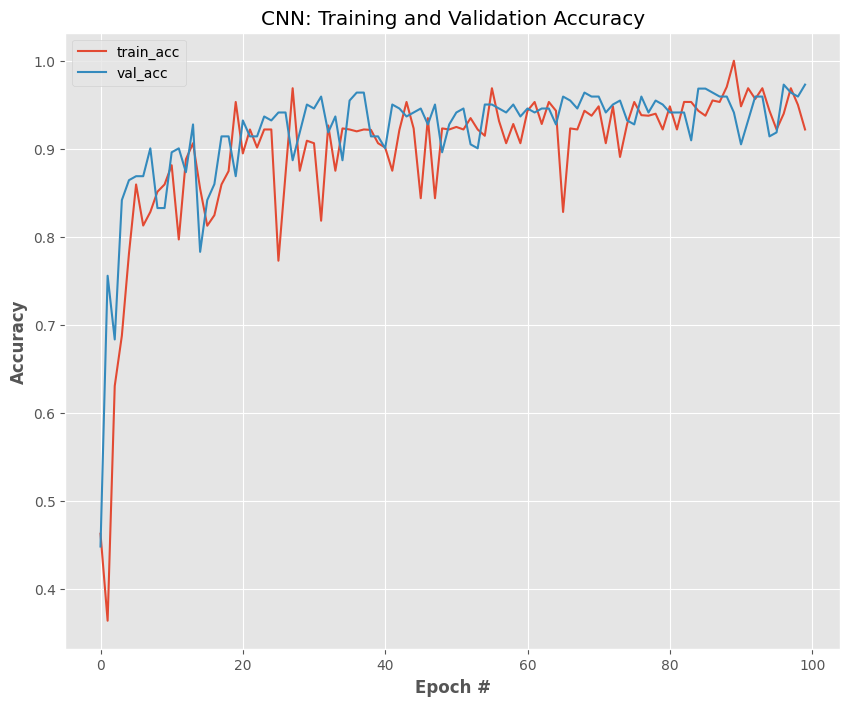

In [23]:
# plot the training and validation accuracy
N = np.arange(0, EPOCH )
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

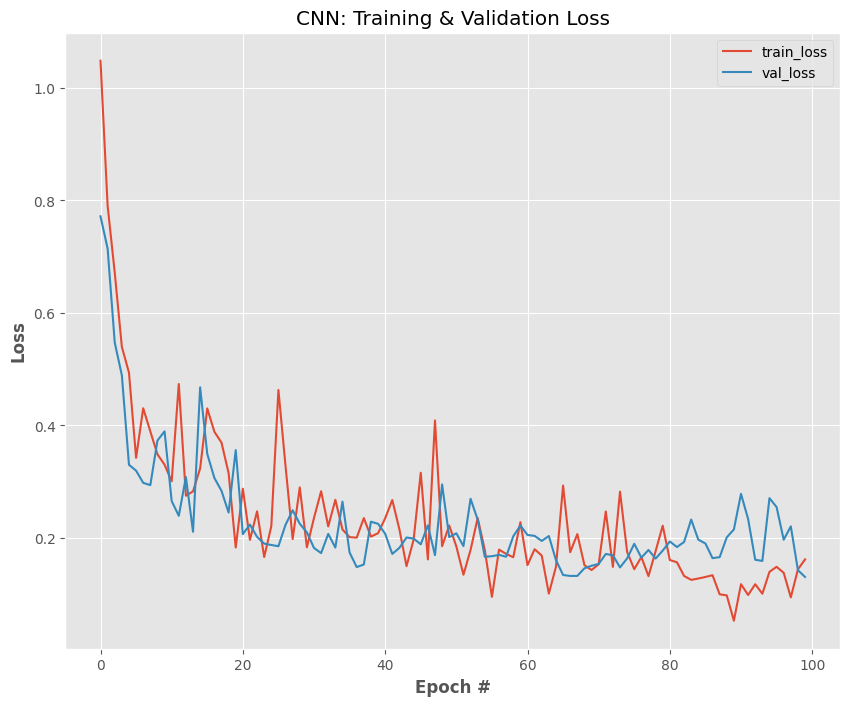

In [24]:
# plot the training and validation loss
N = np.arange(0, EPOCH)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

### Confusion Matrix

[INFO] generating predictions...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


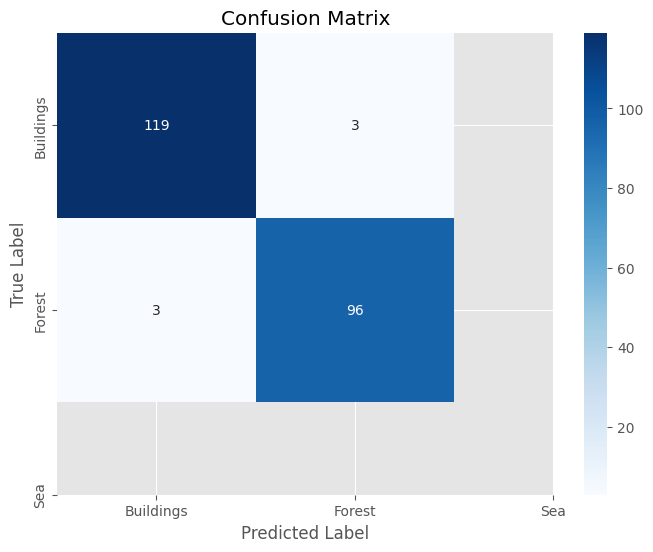

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
print("[INFO] generating predictions...")
test_preds = model.predict(testX)
test_preds = np.argmax(test_preds, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded testY back to class labels
testY_labels = np.argmax(testY, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(testY_labels, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Buildings", "Forest", "Sea"],
            yticklabels=["Buildings", "Forest", "Sea"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

* Training and validation accuracy/loss are plotted to evaluate model performance.

## Step 9: Prediction on Unseen Data

In [26]:
def display_img(img):  # https://justpaste.it/hc5ip
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img)

import imutils

In [27]:
# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders

all_class = ["Buildings", "Forest", "Sea"]


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf= model.predict(image)[0] # [[0.1 , 0.8 , 0.1]]
        print(prd_conf)

        # build the label
        label = all_class[np.argmax(prd_conf)] #[b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)] # [0.1 , 0.8 , 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)

        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


0it [00:00, ?it/s]

* Predictions are made on unseen test images, and the results are displayed.

## Step 10: Deployment on Gradio

In [28]:
import gradio as gr    # https://justpaste.it/bdyzt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline

In [29]:


# # load the model
print("[INFO] loading network and...")
model = load_model("cnn_model_{}.h5".format(100))

[INFO] loading network and...


In [30]:
def predict_image(image):
    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    result = dict()
    result["Buildings"] = round(float(list(preds)[0]), 3)
    result["Forest"] = round(float(list(preds)[1]), 3)
    result["Sea"] = round(float(list(preds)[2]), 3)

    print(result)
    return result

In [ ]:
im = gr.Image()
label = gr.Label(num_top_classes=3)
gr.Interface(fn=predict_image,
             inputs=im,
             outputs=label,
             title="CNN Demo").launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b8b78dfc703d410e28.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


* The trained model is loaded and deployed using Gradio for real-time predictions.

## Conclusion:

---

In this project, a Convolutional Neural Network (CNN) was successfully built and trained to classify images into three categories: Buildings, Forest, and Sea. The model achieved good accuracy on both training and validation datasets. Data augmentation techniques were employed to improve generalization, and the model was deployed using Gradio for real-time predictions. This project demonstrates the effectiveness of CNNs in image classification tasks and provides a foundation for further exploration in deep learning.

## The End


